In [2]:
import yaml
import pickle
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table,Column
import matplotlib as mpl
from astropy import constants, units
from mpl_toolkits.axes_grid1 import make_axes_locatable


from scripts import *

plt.rcParams['font.size'] = 16
path = '/Users/arcticfox/Documents/GitHub/disks_and_outbursts/radmc'
path = '/Users/arcticfox/Documents/disks'

In [3]:
def open_pickles(path):
    with open(os.path.join(path,'diskdata_interpolated.pkl'), 'rb') as infile:
              diskinp = pickle.load(infile)
              ddustsm, ddustlg, tdustsm, tdustlg, dgas, tgas, re, ze = diskinp
    return ddustsm, ddustlg, tdustsm, tdustlg, dgas, tgas, re, ze

## Analytic model for an outburst

In [4]:
outburst_data = Table.read('gaia20eae.csv', format='csv')

(20.0, 14.0)

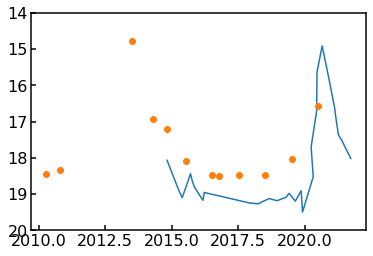

In [5]:
plt.plot(outburst_data['Gaia_G_x'], outburst_data['Gaia_G_y'])
plt.plot(outburst_data['W1_x'][outburst_data['W1_x']>0], 
         outburst_data['W1_y'][outburst_data['W1_x']>0], 'o')
plt.ylim(20,14)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


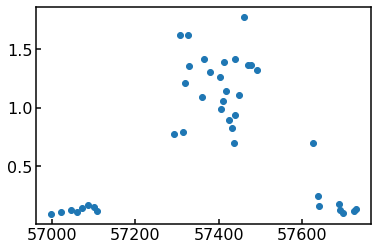

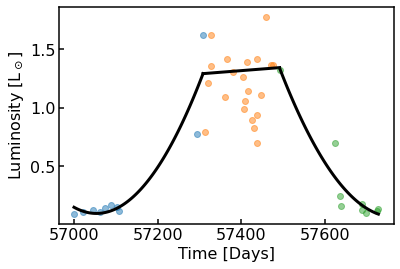

In [6]:
vori_outburst = Table.read('/Users/arcticfox/Documents/GitHub/disks_and_outbursts/radmc/V1118Ori_outburst.csv',
                           format='csv')
sort_v = np.argsort(vori_outburst['V_x'])

# adopting distance of 400 pc from https://arxiv.org/pdf/1501.05287.pdf
# assuming effective temperature of 3700 K from https://arxiv.org/pdf/1501.05287.pdf
# assuming bolometric correction factor of -1.38 from https://arxiv.org/pdf/1307.2657.pdf
BC = -1.38
Mbol_sun = 4.74
apparent = vori_outburst['V_y'][sort_v]
absolute = apparent - 5*np.log10(400) + 5 + BC
lum = 10**(0.4*(Mbol_sun-absolute))
plt.plot(vori_outburst['V_x'][sort_v],lum,'o')

g1 = np.where((vori_outburst['V_x'][sort_v]<57310) & 
              (vori_outburst['V_x'][sort_v]>56000))[0]
g2 = np.where((vori_outburst['V_x'][sort_v]>57310) & 
              (vori_outburst['V_x'][sort_v]<=57480))[0]
g3 = np.where(vori_outburst['V_x'][sort_v]>=57480)[0]

models_x = np.zeros((3,100))
models_y = np.zeros((3,100))
deg = [2,1,2]
fig = plt.figure()
fig.set_facecolor('w')
for i,inds in enumerate([g1,g2,g3]):
    plt.plot(vori_outburst['V_x'][sort_v][inds],
             lum[inds],
             'o',alpha=0.5)
    if i != 1:
        fit = np.polyfit(vori_outburst['V_x'][sort_v][inds],
                         lum[inds],
                         deg=deg[i])
        newx = np.linspace(vori_outburst['V_x'][sort_v][inds][0],
                       vori_outburst['V_x'][sort_v][inds][-1], 100)
    else:
        fit = np.polyfit([vori_outburst['V_x'][sort_v][g1[-1]],
                          vori_outburst['V_x'][sort_v][g3[0]]],
                         [models_y[0][-1], lum[sort_v][g3[0]]+0.02],
                         deg=deg[i])
        newx = np.linspace(vori_outburst['V_x'][sort_v][g1[-1]],
                           vori_outburst['V_x'][sort_v][g3[0]], 100)
    poly = np.poly1d(fit)
    
    plt.plot(newx,poly(newx),'k',lw=3)
    models_x[i]=newx
    models_y[i]=poly(newx)
plt.xlabel('Time [Days]')
plt.ylabel('Luminosity [L$_\odot$]')
plt.savefig('/Users/arcticfox/Documents/disks/figures/twhydrae_comp/outburst_model.png',
            dpi=250, rasterize=True, bbox_inches='tight')

In [7]:
mx = models_x.reshape((300,))
my = models_y.reshape((300,))

sort = np.argsort(mx)
mx=mx[sort][15:]
my=my[sort][15:]
my = my/np.nanmin(my)

(0.0, 18.0)

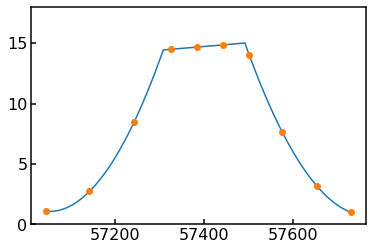

In [8]:
plt.plot(mx,my)
args = np.linspace(0,len(mx)-1,10,dtype=int)
plt.plot(mx[args],my[args],'o')
plt.ylim(0,18)

## TW Hydrae Modeling

$T \propto \left( \frac{100 L_B}{L_B}*T_B^4 \right)^{1/4}$

In [ ]:
path = '/Users/arcticfox/Documents/disks'
Tc_atm = 125
H_c = 15

In [ ]:
L_B = 0.54
T_B = 4110
((10*L_B)/L_B * T_B**4)**(0.25)

### scale height changes

$H$ = 15 AU; R = 150 AU

c_s = 2 $\times 10^4$ [cm s$^{-1}$]

gives temperature of 15K at 150 AU

In [10]:
norm = setup(PATH=path, models=['twhydrae/baseline'], 
             uv=False, run=True, ndust=2,
             disk_params={'r_in':0.1, 'r_out':150.0, 
                          'r_peb':150.0, 'r_snow':0,
                          'Tc_atm':125},
             grid_params={'ntheta':120, 
                          'nr':150, 
                          'n_in':0.05},             
             nphot=10**11)

twhydrae/baseline
saved star spectrum
Saved radmc setup files in /Users/arcticfox/Documents/disks/models/twhydrae/baseline
completed thermal mc
Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dust_temperature.dat
saved raw
Saved gas disk data


In [ ]:
og  = open_pickles('/Users/arcticfox/Documents/disks/models/twhydrae/baseline/') 

In [ ]:
tab = Table(names=['step', 'Tc_atm', 'T_star', 'L_star', 'H_c'])

for i in range(len(args)):
    
    Lfactor = my[args][i]*L_B
    Tc_atm_new = Tc_atm*(Lfactor+L_B)**0.25
    T_star_new = ((Lfactor)/L_B * T_B**4)**(0.25)
    L_star_new = Lfactor+0.0
    
    norm = setup(PATH=path, models=['twhydrae/step_{0:02d}'.format(i)], 
                 uv=False, run=True, ndust=2, 
                 disk_params={'r_in':0.1, 
                              'r_out':150.0, 
                              'r_peb':150.0, 'r_snow':0,
                              'Tc_atm':Tc_atm_new},
                 grid_params={'ntheta':90, 
                              'nr':110, 
                              'n_in':0.05},
                 star_params={'T_star':T_star_new,
                              'L_star':L_star_new},
                 nphot=10**8)
    
    Lnew = open_pickles('/Users/arcticfox/Documents/disks/models/twhydrae/step_{0:02d}/'.format(i))
    f = np.nanmedian((Lnew[3][:,:30]+Lnew[2][:,:30])/(og[3][:,:30]+og[2][:,:30]))
    new_hh = f**0.5
    H_c_new = H_c*new_hh
    tab.add_row([i,Tc_atm_new,T_star_new,L_star_new,H_c_new])
    
    
    norm = setup(PATH=path, models=['twhydrae/step_{0:02d}'.format(i)], 
                 uv=False, run=True, ndust=2, 
                 H_c=H_c_new,
                 disk_params={'r_in':0.1, 
                              'r_out':150.0, 
                              'r_peb':150.0, 'r_snow':0,
                              'Tc_atm':Tc_atm_new},
                 grid_params={'ntheta':90, 
                              'nr':110, 
                              'n_in':0.05},
                 star_params={'T_star':T_star_new,
                              'L_star':L_star_new},
                 nphot=10**10)

In [ ]:
tab.add_column(Column(args, 'args'))
tab.write('/Users/arcticfox/Documents/GitHub/disks_and_outbursts/radmc/params_per_step.tab', 
          format='ascii')

In [ ]:
np.save('/Users/arcticfox/Documents/GitHub/disks_and_outbursts/radmc/outburst_model.npy',
        [mx,my])